In [95]:
#installing the neccessary packages
!pip install pmdarima

#importing the required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
from sklearn.utils import check_array

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, Bidirectional, Dense, MaxPooling1D, Conv1D, Flatten, TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint

#writing the code for the mean percentage error
def mean_percentage_error(y_true, y_pred):

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    


In [47]:
dataset = pd.read_csv('candy_production.csv', index_col = 0,parse_dates = [0], squeeze = True)

In [6]:
dataset.head()

observation_date
1972-01-01    85.6945
1972-02-01    71.8200
1972-03-01    66.0229
1972-04-01    64.5645
1972-05-01    65.0100
Name: IPG3113N, dtype: float64

In [7]:
type(dataset[0])

numpy.float64

In [8]:
dataset.head(10)

observation_date
1972-01-01     85.6945
1972-02-01     71.8200
1972-03-01     66.0229
1972-04-01     64.5645
1972-05-01     65.0100
1972-06-01     67.6467
1972-07-01     69.0429
1972-08-01     70.8370
1972-09-01     75.0462
1972-10-01    106.9289
Name: IPG3113N, dtype: float64

In [9]:
upsampled_dataset = dataset.resample('M').asfreq()
upsampled_dataset.head(10)

observation_date
1972-01-31   NaN
1972-02-29   NaN
1972-03-31   NaN
1972-04-30   NaN
1972-05-31   NaN
1972-06-30   NaN
1972-07-31   NaN
1972-08-31   NaN
1972-09-30   NaN
1972-10-31   NaN
Freq: M, Name: IPG3113N, dtype: float64

In [10]:
the_final_ds = upsampled_dataset + dataset
the_final_ds.head()

observation_date
1972-01-01   NaN
1972-01-31   NaN
1972-02-01   NaN
1972-02-29   NaN
1972-03-01   NaN
Name: IPG3113N, dtype: float64

In [11]:
the_final_ds[dataset.index] = dataset
#the_final_ds.plot()
the_final_ds.head()

observation_date
1972-01-01    85.6945
1972-01-31        NaN
1972-02-01    71.8200
1972-02-29        NaN
1972-03-01    66.0229
Name: IPG3113N, dtype: float64

In [12]:

interpolated = the_final_ds.interpolate(method='linear')
#interpolated.to_csv('final_candy_dataset.csv')
interpolated.head(), len(interpolated)

(observation_date
 1972-01-01    85.69450
 1972-01-31    78.75725
 1972-02-01    71.82000
 1972-02-29    68.92145
 1972-03-01    66.02290
 Name: IPG3113N, dtype: float64, 1096)

In [13]:
#Part 2  - This is starting the Exploratory Data analysis

#bringing in the dataset we are testing
this_dataset = pd.read_csv('final_candy_dataset.csv', index_col = 0,parse_dates = [0], squeeze = True)
this_dataset.head()

observation_date
1972-01-01    85.69450
1972-01-31    78.75725
1972-02-01    71.82000
1972-02-29    68.92145
1972-03-01    66.02290
Name: IPG3113N, dtype: float64

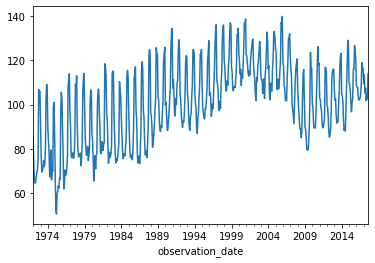

In [14]:

#A plotting of the Original dataset
dataset.plot()
plt.show()

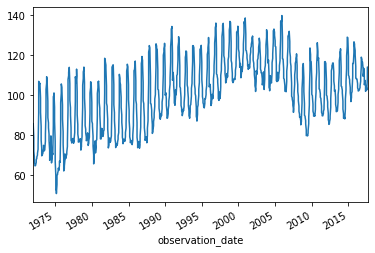

In [15]:

#a plotting of the new dataset
this_dataset.plot()
plt.show()

In [16]:
#Let us have a look at Quantitative metrics
dataset.describe()

count    548.000000
mean     100.662524
std       18.052931
min       50.668900
25%       87.862475
50%      102.278550
75%      114.691900
max      139.915300
Name: IPG3113N, dtype: float64

In [17]:

#doing EDA on the time series dataset
this_dataset.describe()

count    1096.000000
mean      100.675465
std        17.760245
min        50.668900
25%        88.084075
50%       102.379800
75%       114.093325
max       139.915300
Name: IPG3113N, dtype: float64

In [18]:
##We are vehemently seeing that the dataset is evenly distruibuted between each other 
#Now resampling to the year to see a General overview of how the demand was per year
this_dataset_year = this_dataset.resample('Y').mean() 
this_dataset_year.head()

observation_date
1972-12-31    79.631533
1973-12-31    83.131733
1974-12-31    80.024617
1975-12-31    71.603994
1976-12-31    81.839535
Freq: A-DEC, Name: IPG3113N, dtype: float64

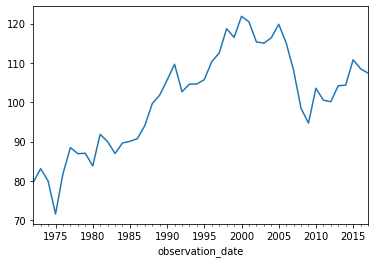

In [19]:
#plotting to see how the dataset was
this_dataset_year.plot()
plt.show()

In [20]:
#Now check how much each month
this_dataset_df = this_dataset.to_frame()
this_dataset_df.head()

,IPG3113N
observation_date,
1972-01-01,85.69450
1972-01-31,78.75725
1972-02-01,71.82000
1972-02-29,68.92145
1972-03-01,66.02290


In [21]:
this_dataset_df.index


DatetimeIndex(['1972-01-01', '1972-01-31', '1972-02-01', '1972-02-29',
               '1972-03-01', '1972-03-31', '1972-04-01', '1972-04-30',
               '1972-05-01', '1972-05-31',
               ...
               '2017-04-01', '2017-04-30', '2017-05-01', '2017-05-31',
               '2017-06-01', '2017-06-30', '2017-07-01', '2017-07-31',
               '2017-08-01', '2017-08-31'],
              dtype='datetime64[ns]', name='observation_date', length=1096, freq=None)

In [22]:
this_dataset_df['Month'] = this_dataset_df.index.month
this_dataset_df.head()

,IPG3113N,Month
observation_date,,
1972-01-01,85.69450,1
1972-01-31,78.75725,1
1972-02-01,71.82000,2
1972-02-29,68.92145,2
1972-03-01,66.02290,3


In [23]:
this_dataset_df.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['JAN', 'FEB','MAR','APR','MAY','JUNE','JULY','AUG','SEP','OCT','NOV','DEC'], inplace=True)

In [24]:
this_dataset_df.columns = ["Amount", "Month"]

In [25]:
this_dataset_df.head()

,Amount,Month
observation_date,,
1972-01-01,85.69450,JAN
1972-01-31,78.75725,JAN
1972-02-01,71.82000,FEB
1972-02-29,68.92145,FEB
1972-03-01,66.02290,MAR


In [26]:
the_groups = this_dataset_df.groupby("Month", sort=False)
final_values = the_groups.head()
the_groups.count()

,Amount
Month,
JAN,92
FEB,92
MAR,92
APR,92
MAY,92
JUNE,92
JULY,92
AUG,92
SEP,90


In [27]:
final_values.head()

,Amount,Month
observation_date,,
1972-01-01,85.69450,JAN
1972-01-31,78.75725,JAN
1972-02-01,71.82000,FEB
1972-02-29,68.92145,FEB
1972-03-01,66.02290,MAR


<Figure size 1600x800 with 0 Axes>

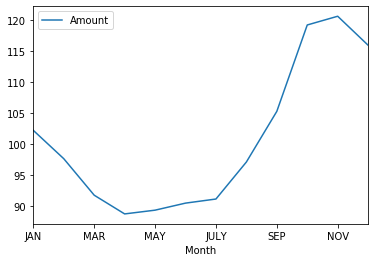

In [28]:
aggregation = {"Amount":"mean"}
final_values = the_groups.agg(aggregation)
#plt.xticks(['JAN', 'FEB','MAR','APR','MAY','JUNE','JULY','AUG','SEP','OCT','NOV','DEC'])
plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

final_values.plot()
plt.show()

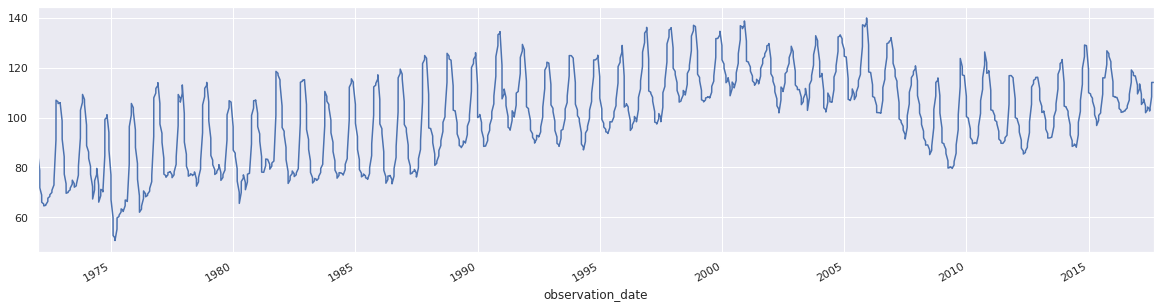

In [29]:
#doing more EDA on the resampled datas
sns.set(rc = {'figure.figsize':(20,5)})
this_dataset.plot()

In [30]:

#set the frequency
this_dataset.index

DatetimeIndex(['1972-01-01', '1972-01-31', '1972-02-01', '1972-02-29',
               '1972-03-01', '1972-03-31', '1972-04-01', '1972-04-30',
               '1972-05-01', '1972-05-31',
               ...
               '2017-04-01', '2017-04-30', '2017-05-01', '2017-05-31',
               '2017-06-01', '2017-06-30', '2017-07-01', '2017-07-31',
               '2017-08-01', '2017-08-31'],
              dtype='datetime64[ns]', name='observation_date', length=1096, freq=None)

In [31]:
dataset.index.freq = pd.infer_freq(dataset.index)

In [32]:
dataset.index

DatetimeIndex(['1972-01-01', '1972-02-01', '1972-03-01', '1972-04-01',
               '1972-05-01', '1972-06-01', '1972-07-01', '1972-08-01',
               '1972-09-01', '1972-10-01',
               ...
               '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01',
               '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01',
               '2017-07-01', '2017-08-01'],
              dtype='datetime64[ns]', name='observation_date', length=548, freq='MS')

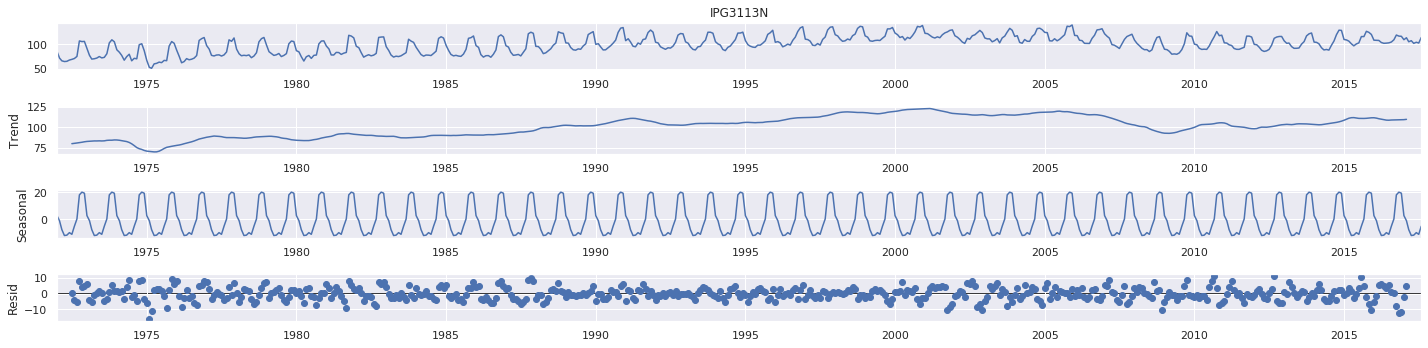

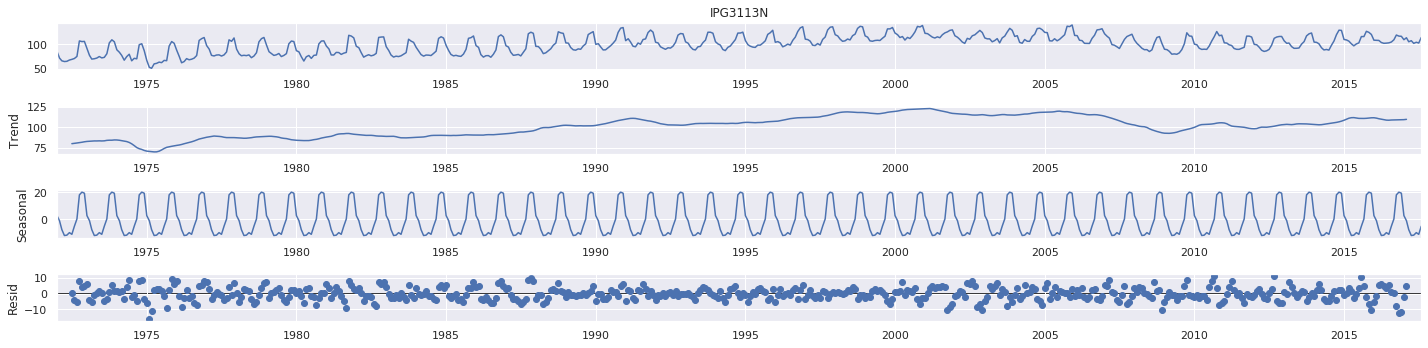

In [33]:



#let us perform Seasonl decomposition
result = seasonal_decompose(dataset)
sns.set(rc={'figure.figsize': (20,5)})
result.plot()

#there is a most likely a seasonal componenet in the data

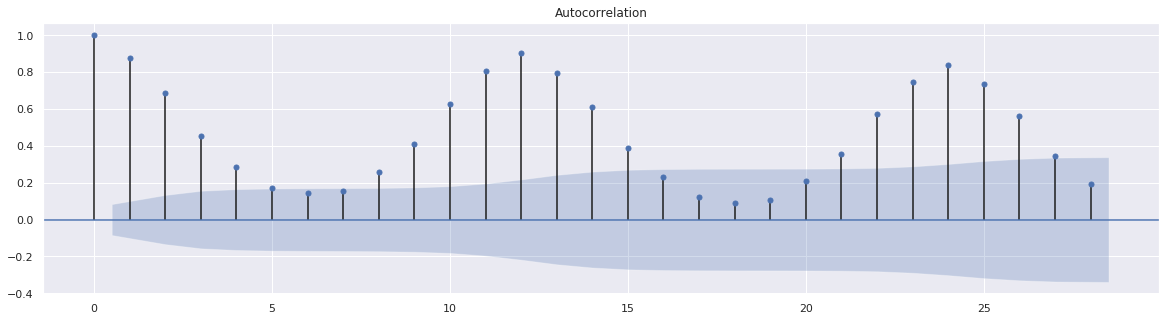

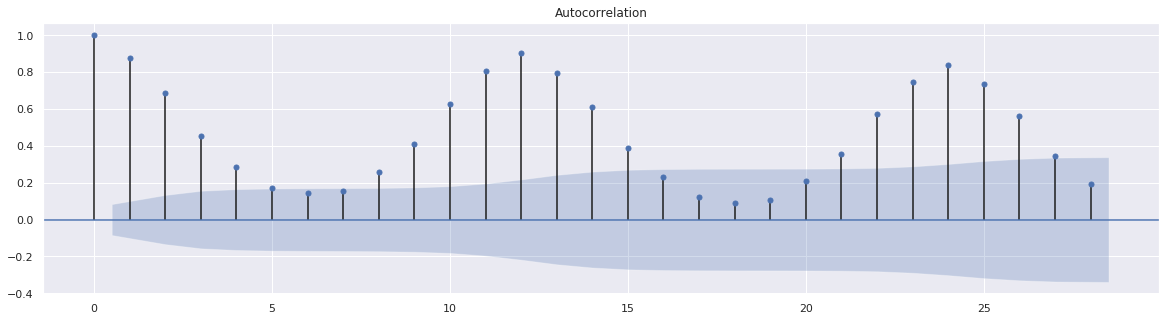

In [34]:
plot_acf(dataset)

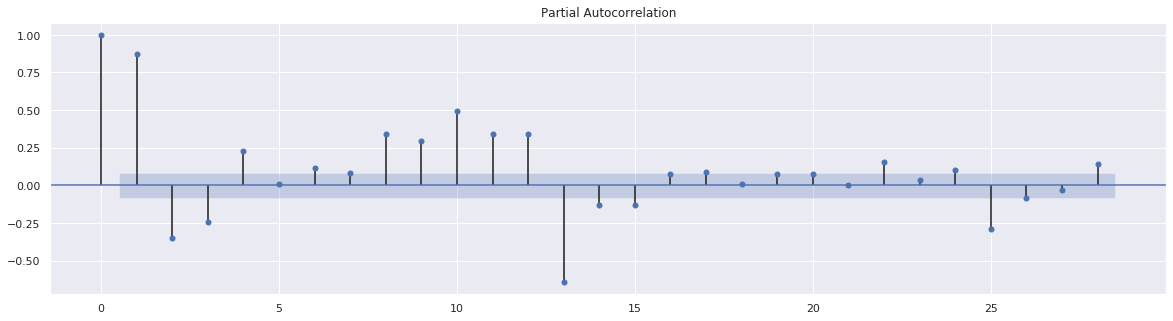

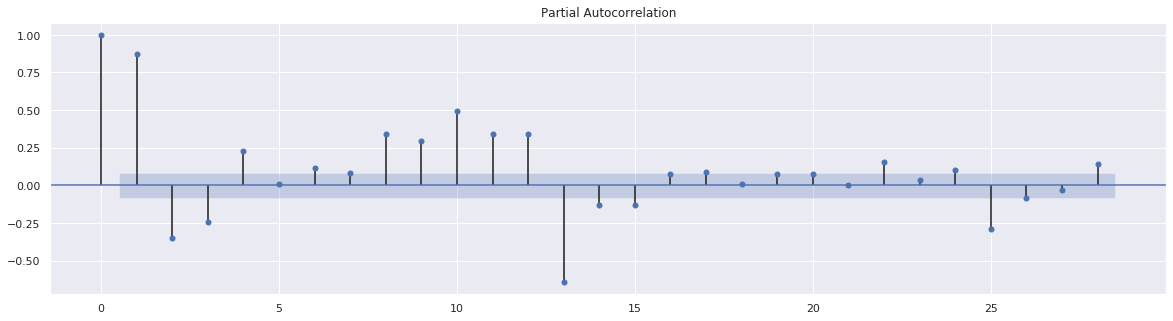

In [35]:

plot_pacf(dataset)

#from the acf plot we can clearly see that there is a trend reputation at every 12 months

/home/michael/anaconda3/envs/tensorlow-gpu/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


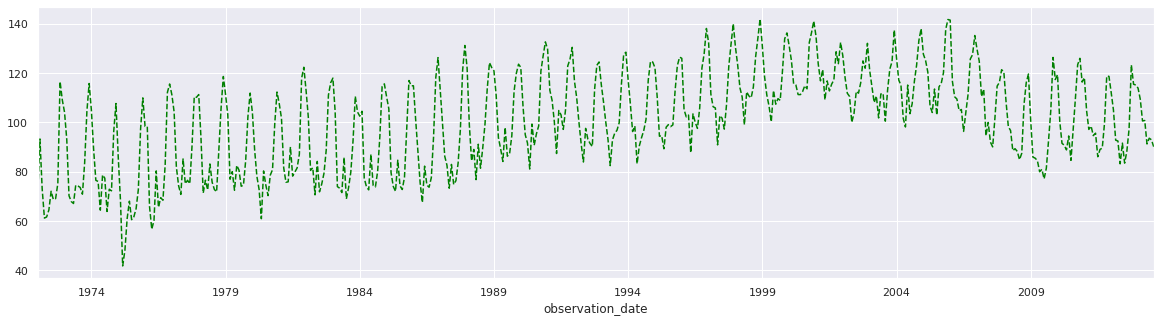

In [36]:
#implementing an Optimized version of Holt-Winter method
#splitting the dataset to leave 4 years of analysis out of it 
train = dataset[:'2013-08-01']
test = dataset['2013-09-01':]

holt_model = ExponentialSmoothing(train, seasonal_periods=4, trend='add', seasonal = "mul", damped = True).fit(use_boxcox = True)

holt_model.fittedvalues.plot(style='--', color='green')

In [37]:
len(train), len(test)

(500, 48)

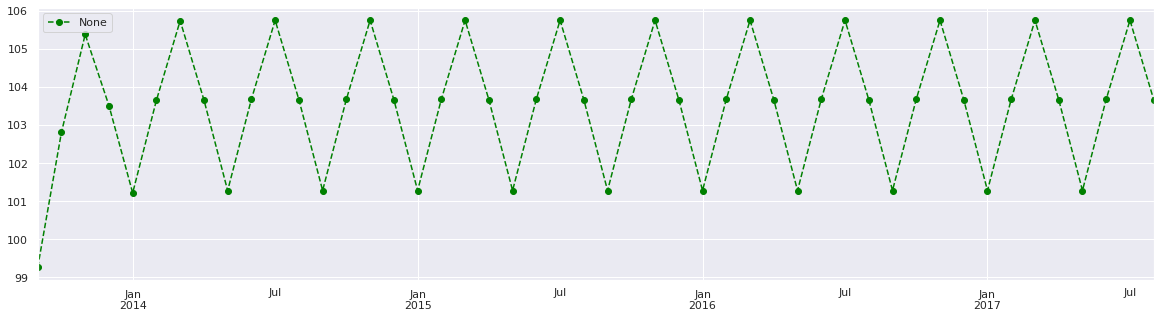

In [38]:

predicted_values = holt_model.forecast(48)
predicted_values.plot(style='--', marker='o', color='green', legend=True)

In [39]:
#look at the model metrics
mae_expo_smt = mean_absolute_error(test, predicted_values)
mape_expo_smt = mean_percentage_error(test, predicted_values)
mae_expo_smt, mape_expo_smt

(8.605539521168293, 7.688113004525951)

In [40]:
#Now implementing ARIMA in the form of auto-arimal
model  = auto_arima(train, trace = True, error_action='ignore', suppress_warnings=True)
model.fit(train)

predictions_arima = model.predict(n_periods = 48)
len(predictions_arima)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3554.180, BIC=3579.455, Time=0.345 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3633.617, BIC=3642.042, Time=0.014 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=3600.362, BIC=3613.000, Time=0.071 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3609.569, BIC=3622.207, Time=0.108 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=3631.622, BIC=3635.834, Time=0.013 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3565.965, BIC=3587.028, Time=0.203 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=3513.218, BIC=3534.282, Time=0.323 seconds
Near non-invertible roots for order (2, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)
Fit ARIMA: (3, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=3345.099, BIC=3374.588, Time=0.706 seconds
Fit ARIMA: (3,

48

In [41]:
#Now to find the Mean absolute error and mean Percentage error using the Auto-Arima
mae_arima = mean_absolute_error(test, predictions_arima)
mape_arima = mean_percentage_error(test, predictions_arima)
mae_arima, mape_arima




(6.318930469848945, 5.69729796230049)

In [42]:
len(dataset.values)

548

In [48]:
dataset.values

array([ 85.6945,  71.82  ,  66.0229,  64.5645,  65.01  ,  67.6467,
        69.0429,  70.837 ,  75.0462, 106.9289, 105.5962, 105.9673,
        91.2997,  77.27  ,  69.611 ,  70.2986,  71.6822,  74.8635,
        72.0464,  73.1748,  80.5915, 102.92  , 109.2524, 105.221 ,
        88.6985,  83.6098,  77.23  ,  67.3209,  74.6196,  79.5858,
        66.0568,  71.1864,  70.175 ,  99.2212, 101.1201,  86.893 ,
        67.0117,  52.6964,  50.6689,  59.7613,  60.8277,  63.3629,
        62.3089,  66.9021,  66.32  ,  96.3411, 105.6285, 102.1819,
        87.9578,  75.1878,  62.0101,  64.4758,  70.5454,  68.2086,
        69.3122,  71.5922,  76.9073, 107.9049, 111.6584, 113.9655,
        97.3515,  90.0083,  77.2871,  76.0459,  77.9316,  78.3077,
        75.8701,  78.1822,  84.2727, 109.2254, 106.1656, 113.0575,
        90.1141,  80.4678,  76.464 ,  77.4211,  76.7081,  78.1769,
        72.4653,  75.9054,  82.732 , 105.0435, 111.6915, 114.0821,
        98.6382,  84.7727,  81.0653,  77.1607,  78.378 ,  81.0

In [72]:
#now time to run with some LSTMs
dataset = dataset.values
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))

#a utility function to create datasets and make things work more efficiently
def create_dataset(data, look_back = 1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i + look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)


look_back = 15
X_train, Y_train = create_dataset(dataset[:], look_back)

#reshaping to be accepted by the LSTM, (samples, timesteps, features)
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_train.shape, X_train_reshaped.shape

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [50]:
#splitting it manually
X_test = X_train_reshaped[(len(X_train_reshaped) - 48):]
X_train_reshaped = X_train_reshaped[: (len(X_train_reshaped) - 48)]
len(X_test) + len(X_train_reshaped)

517

In [60]:
#splitting it manually
Y_test = Y_train[(len(Y_train) - 48):]
Y_train = Y_train[: (len(Y_train) - 48)]
len(Y_test) + len(Y_train)

517

In [62]:
Y_test.shape, Y_train.shape

((48,), (469,))

In [53]:
X_test.shape, X_train_reshaped.shape

((48, 1, 30), (469, 1, 30))

In [71]:
#building the model
model = Sequential()
model.add(Bidirectional(LSTM(300,activation = 'relu',return_sequences= True,input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))))
model.add(Bidirectional(LSTM(200,activation = 'relu')))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mae', 'mape'])

checkpoint = ModelCheckpoint('lstm_network.h5', monitor = "mean_absolute_error", save_best_only= True, verbose = 1)
early_stopping = EarlyStopping(monitor= "mean_absolute_error", patience = 20, )
history = model.fit(X_train_reshaped, Y_train, epochs=250, batch_size=32, verbose=1,validation_data = (X_test, Y_test),callbacks = [checkpoint, early_stopping] , shuffle=False)

model.summary()

Train on 469 samples, validate on 48 samples
Epoch 1/250
469/469 [==============================] - 4s 9ms/step - loss: 1614.2647 - mean_absolute_error: 30.8459 - mean_absolute_percentage_error: 33.2104 - val_loss: 298.1894 - val_mean_absolute_error: 14.7975 - val_mean_absolute_percentage_error: 13.0810

Epoch 00001: mean_absolute_error improved from inf to 30.84592, saving model to lstm_network.h5
Epoch 2/250
469/469 [==============================] - 1s 2ms/step - loss: 232.0137 - mean_absolute_error: 12.2107 - mean_absolute_percentage_error: 12.1851 - val_loss: 153.9016 - val_mean_absolute_error: 10.2865 - val_mean_absolute_percentage_error: 9.0818

Epoch 00002: mean_absolute_error improved from 30.84592 to 12.21074, saving model to lstm_network.h5
Epoch 3/250
469/469 [==============================] - 1s 2ms/step - loss: 183.4982 - mean_absolute_error: 10.3609 - mean_absolute_percentage_error: 10.3412 - val_loss: 65.5778 - val_mean_absolute_error: 6.4637 - val_mean_absolute_percent

Epoch 25/250
469/469 [==============================] - 1s 2ms/step - loss: 68.9010 - mean_absolute_error: 6.5493 - mean_absolute_percentage_error: 6.5417 - val_loss: 48.8802 - val_mean_absolute_error: 5.5457 - val_mean_absolute_percentage_error: 4.9776

Epoch 00025: mean_absolute_error did not improve from 6.50053
Epoch 26/250
469/469 [==============================] - 1s 2ms/step - loss: 67.1235 - mean_absolute_error: 6.4170 - mean_absolute_percentage_error: 6.5254 - val_loss: 49.0320 - val_mean_absolute_error: 5.8699 - val_mean_absolute_percentage_error: 5.4185

Epoch 00026: mean_absolute_error improved from 6.50053 to 6.41698, saving model to lstm_network.h5
Epoch 27/250
469/469 [==============================] - 1s 2ms/step - loss: 75.0820 - mean_absolute_error: 6.7584 - mean_absolute_percentage_error: 6.7552 - val_loss: 62.9963 - val_mean_absolute_error: 6.8732 - val_mean_absolute_percentage_error: 6.3010

Epoch 00027: mean_absolute_error did not improve from 6.41698
Epoch 28/250

In [59]:
model.save("lstm_network_1.h5")

In [60]:
X_train[-1].shape

(30,)

In [61]:
#predicting
x_value = np.reshape(X_train_reshaped[468], (1, 1, 30))
train_predict = model.predict(x_value)
train_predict

array([[91.41052]], dtype=float32)

In [62]:
type(X_train[-1])

numpy.ndarray

In [64]:
#writing a utility function to generate 48 values in total
#make a prediction on the last value
#take the last array and remove the first element and append the prediction,
#repeat the above steps infinitely

"""
predictions = []
pred_array = X_train[-1]

for i in range(len(test)):
    entry = np.reshape(pred_array, (1, 1, 30))
    y_hat = model.predict(entry)
    pred_array = np.delete(pred_array, 0)
    pred_array = np.append(pred_array, y_hat)
    predictions.append(float(y_hat))

"""
predictions = model.predict(X_test)

len(predictions)
    

48

In [68]:
predictions = np.reshape(predictions, (predictions.shape[0],))
predictions 

array([ 96.00502 , 104.065445, 112.592384, 117.151535, 115.88777 ,
       108.169846, 101.11774 ,  95.68603 ,  93.255936,  90.51104 ,
        89.45447 ,  90.79314 ,  95.88608 , 104.71663 , 112.4471  ,
       116.91695 , 117.259026, 110.22421 , 104.19844 ,  99.79436 ,
        97.56172 ,  95.202225,  94.580124,  96.109436, 103.06262 ,
       114.10547 , 123.615265, 128.6493  , 124.569016, 112.31426 ,
       107.43328 , 101.773224, 100.39606 ,  96.28643 ,  97.02149 ,
        97.75249 , 104.67969 , 110.205154, 118.52908 , 119.53214 ,
       115.962654, 106.74574 , 103.12912 , 100.52971 ,  99.09668 ,
        97.73503 ,  98.93818 , 100.55823 ], dtype=float32)

In [69]:
mean_absolute_error(predictions, test), mean_percentage_error(predictions, test)

(6.598794524383545, 6.264827963840744)

In [77]:
#reshaping all the tensors to perfect all inputs
n_features = 1
X_train_reshaped = np.reshape(X_train_reshaped, (X_train_reshaped.shape[0], look_back, n_features))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, n_features))

In [82]:
X_train_reshaped.shape, X_test.shape

((469, 30, 1), (48, 30, 1))

In [102]:
#Now to provide features for a machine learning algorithm
#build a convolutional network
model_cnn = Sequential()

model_cnn.add(Conv1D(filters = 386, kernel_size = 2, activation = "relu", input_shape = (look_back, n_features)))
model_cnn.add(Conv1D(filters = 256, kernel_size = 2, activation = "relu"))
model_cnn.add(Conv1D(filters = 128, kernel_size = 2, activation = "relu"))
model_cnn.add(MaxPooling1D(pool_size = 2))

model_cnn.add(Flatten())
model_cnn.add(Dense(384, activation = "relu"))
model_cnn.add(Dense(256, activation = "relu"))
model_cnn.add(Dense(128, activation = "relu"))
model_cnn.add(Dense(1))

model_cnn.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mae', 'mape'])

model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 29, 386)           1158      
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 28, 256)           197888    
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 27, 128)           65664     
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 13, 128)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1664)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 384)               639360    
_________________________________________________________________
dense_21 (Dense)             (None, 256)               98560     
__________

In [104]:
checkpoint = ModelCheckpoint('cnn_network.h5', monitor = "val_mean_absolute_error", save_best_only= True, verbose = 1)
early_stopping = EarlyStopping(monitor= "val_mean_absolute_error", patience = 20, )
history = model_cnn.fit(X_train_reshaped, Y_train, epochs=100, batch_size=32, verbose=1,validation_data = (X_test, Y_test),callbacks = [checkpoint, early_stopping] , shuffle=False)


Train on 469 samples, validate on 48 samples
Epoch 1/100
469/469 [==============================] - 1s 1ms/step - loss: 24.4396 - mean_absolute_error: 3.7925 - mean_absolute_percentage_error: 3.9301 - val_loss: 49.0946 - val_mean_absolute_error: 5.8682 - val_mean_absolute_percentage_error: 5.3320

Epoch 00001: val_mean_absolute_error improved from inf to 5.86817, saving model to cnn_network.h5
Epoch 2/100
469/469 [==============================] - 1s 1ms/step - loss: 26.4513 - mean_absolute_error: 3.9187 - mean_absolute_percentage_error: 3.9822 - val_loss: 60.7829 - val_mean_absolute_error: 6.5935 - val_mean_absolute_percentage_error: 6.0064

Epoch 00002: val_mean_absolute_error did not improve from 5.86817
Epoch 3/100
469/469 [==============================] - 1s 1ms/step - loss: 28.0758 - mean_absolute_error: 4.1046 - mean_absolute_percentage_error: 4.1501 - val_loss: 73.7197 - val_mean_absolute_error: 7.4616 - val_mean_absolute_percentage_error: 6.8200

Epoch 00003: val_mean_absolut


Epoch 00025: val_mean_absolute_error did not improve from 4.38816
Epoch 26/100
469/469 [==============================] - 1s 2ms/step - loss: 21.8012 - mean_absolute_error: 3.7193 - mean_absolute_percentage_error: 3.7967 - val_loss: 27.6997 - val_mean_absolute_error: 4.2334 - val_mean_absolute_percentage_error: 3.8270

Epoch 00026: val_mean_absolute_error improved from 4.38816 to 4.23344, saving model to cnn_network.h5
Epoch 27/100
469/469 [==============================] - 1s 1ms/step - loss: 22.5047 - mean_absolute_error: 3.7660 - mean_absolute_percentage_error: 3.8328 - val_loss: 24.9993 - val_mean_absolute_error: 3.9495 - val_mean_absolute_percentage_error: 3.5728

Epoch 00027: val_mean_absolute_error improved from 4.23344 to 3.94950, saving model to cnn_network.h5
Epoch 28/100
469/469 [==============================] - 1s 1ms/step - loss: 18.6767 - mean_absolute_error: 3.3896 - mean_absolute_percentage_error: 3.4670 - val_loss: 26.4229 - val_mean_absolute_error: 4.0339 - val_mean

469/469 [==============================] - 1s 1ms/step - loss: 29.5807 - mean_absolute_error: 4.5076 - mean_absolute_percentage_error: 4.6647 - val_loss: 26.4888 - val_mean_absolute_error: 4.0850 - val_mean_absolute_percentage_error: 3.7023

Epoch 00051: val_mean_absolute_error did not improve from 3.78326
Epoch 52/100
469/469 [==============================] - 1s 1ms/step - loss: 22.2817 - mean_absolute_error: 3.8215 - mean_absolute_percentage_error: 3.9566 - val_loss: 50.4499 - val_mean_absolute_error: 5.8264 - val_mean_absolute_percentage_error: 5.2918

Epoch 00052: val_mean_absolute_error did not improve from 3.78326
Epoch 53/100
469/469 [==============================] - 1s 1ms/step - loss: 25.2715 - mean_absolute_error: 4.0034 - mean_absolute_percentage_error: 4.0719 - val_loss: 55.4172 - val_mean_absolute_error: 6.2746 - val_mean_absolute_percentage_error: 5.7240

Epoch 00053: val_mean_absolute_error did not improve from 3.78326
Epoch 54/100
469/469 [============================

In [113]:
predictions_cnn = model_cnn.predict(X_test)
predictions_cnn = np.reshape(predictions_cnn, (48))

In [114]:
mean_absolute_error(predictions_cnn, test), mean_percentage_error(predictions_cnn, test)

(10.949616027577719, 11.304537501637734)